<a href="https://colab.research.google.com/github/Jaesu26/aifactory-water-demand-forecasting/blob/main/2022-11-26-%EB%86%8D%EC%B4%8C%EC%A7%80%EC%97%AD-%EC%88%98%EB%8F%97%EB%AC%BC-%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [2022 제2회 K-water AI 경진대회] 수돗물 수요예측 AI 알고리즘 개발

- [2022-Task 2] 아포 : 경상북도 김천시 아포읍

In [ ]:
# !pip install xgboost==0.90

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import easydict
import random
import os
import gc

import statsmodels.graphics.tsaplots as sgt

from typing import Any, Dict, List, Optional, Sequence, Tuple, Union
from numpy.typing import NDArray

from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore') 

In [2]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [3]:
%cd  '/content/drive/MyDrive/Colab Notebooks/농촌지역-수돗물-수요예측'

/content/drive/MyDrive/Colab Notebooks/농촌지역-수돗물-수요예측


- 데이터 불러오기

In [4]:
train_path = './data/data_tr_apo.csv'
test_path = './data/data_ts_apo.csv'
submission_path = './data/sample_apo.csv'

In [5]:
df = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [6]:
# 변수 이름을 영문으로 변경
df = df.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})
test = test.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})


# 날짜를 datetime 형식으로 변경
df['datetime'] = pd.to_datetime(df['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

- 가중치 저장폴더

In [7]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

- 데이터 설명

`-` 유량: 단위시간 당 얼마만큼의 체적에 해당하는 액체가 이동했는지 나타냄 ($m^3/h$)

`-` 적산값: 1시간마다 측정한 값이 계속 누적 (i.g. $100 \xrightarrow{~+170~} 270 \xrightarrow{~+150~} 420 \xrightarrow{~+110~} 530$)  

`-` 적산차값: 적산의 매시간 차이를 계산 ($\approx$ 시간 단위 공급량,$\quad$ i.g. $\operatorname{NA},170, 150, 110$)

## 전처리

`-` 데이터는 항상 시간상의 순서대로 존재해야 한다

`-` 데이터에서 특정 시점의 적산차값이 결측치일 수도 있지만 특정 시점 자체가 누락되면 안된다 

`-` 그래프에 추세는 없어보인다

`-` 데이터에 결측치가 존재한다

`-` 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채워주자

`-` 이상치가 존재한다 (예컨대 음수 또는 매우 큰 양수)

`-` 후처리는 반올림

- 이상치와 결측치 처리

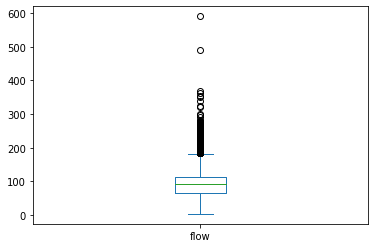

In [ ]:
df.query('0 < flow < 1000').flow.plot.box()

`-` 100,000을 넘기는 매우 큰 값이 존재한다

`-` 또한, 음수값도 존재하는데 이들은 모두 -100,000보다 작다

`-` 위와 같은 경우는 계측기에 문제가 있는 것으로 보인다

`-` 0인 경우도 존재한는데 계측기의 오류 또는 모종의 이유로 물이 흐르지 않은 것으로 보인다 (i.g. 배수지 청소로 인해 단수)

`-` 이런 경우 적산차값만 사용해 예측하는 것은 불가능하므로 이상치로 처리하겠다  

`-` 한편, 큰 양수의 경우 이상치의 기준은 400을 넘지 않는 값 중 최댓값으로 하겠다 (위의 box-plot에 기반함, IQR을 넘는 값들을 보면 400부터 절단되어 빈도수가 매우 작아짐)

`-` 이상치와 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 대체하겠다

In [8]:
def fillna(time_series: pd.Series, m: int = 24) -> pd.Series:
    """m 시점 앞의 값으로 결측치를 재귀적으로 채우고 데이터를 반환"""
    assert time_series.ndim == 1
    time_series = time_series.copy()  # 원본이 변하지 않도록 복제 
    na_idx = time_series[time_series.isnull()].index.values
    fill_idx = na_idx - m  # m 시점 앞의 값으로 결측치를 채운다
    fill_idx = np.where(fill_idx < 0, fill_idx + m, fill_idx)

    if not na_idx.size:                  # 결측치가 존재하지 않으면 원본을 반환
        return time_series
    if np.in1d(fill_idx, na_idx).all():  # m 시점 앞의 값이 결측치면 원본을 반환
        return time_series

    time_series[na_idx] = time_series[fill_idx]
    return fillna(time_series, m)

In [9]:
# 이상치는 결측치로 처리한다
tmp = df.flow[df.flow < 400].max()
df['flow'] = df['flow'].apply(lambda x: x if 0 < x <= tmp else np.nan)

In [10]:
# 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채운다 
df['flow'] = fillna(df['flow']).fillna(method='ffill').fillna(0)

## 시각화

In [ ]:
sns.set_theme(style='white')

In [ ]:
# df = df.set_index('datetime')

In [ ]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).\
groupby('year').flow.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2017,8759.0,94.024775,39.571984,3.0,66.0,89.0,115.0,273.0
2018,8760.0,102.403196,48.363907,4.0,68.0,93.0,113.0,370.0
2019,8760.0,99.048744,48.780636,15.0,63.0,91.0,109.0,340.0
2020,8784.0,101.770947,49.726643,4.0,64.0,94.0,113.0,364.0


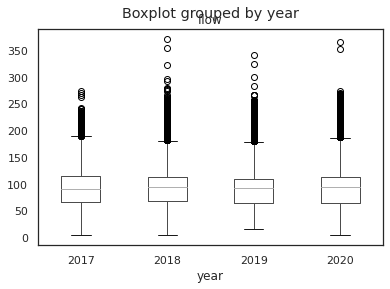

In [ ]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).boxplot(column='flow', by='year', grid=False)

`-` 적산차의 경우 2017년과 나머지 연도는 다른 분포를 띄고있다 (평균과 분산이 더 커졌다)

`-` 원인은 200을 넘어가는 큰 값의 빈도수에 있다

`-` 모델 훈련에 2017년 데이터를 사용하지 않는게 미래를 예측하는데 더 나을 수 있다

In [ ]:
df.iloc[7600]

datetime      2017-11-13 17:00:00
flow                         80.0
start_hour                     17
Name: 7600, dtype: object

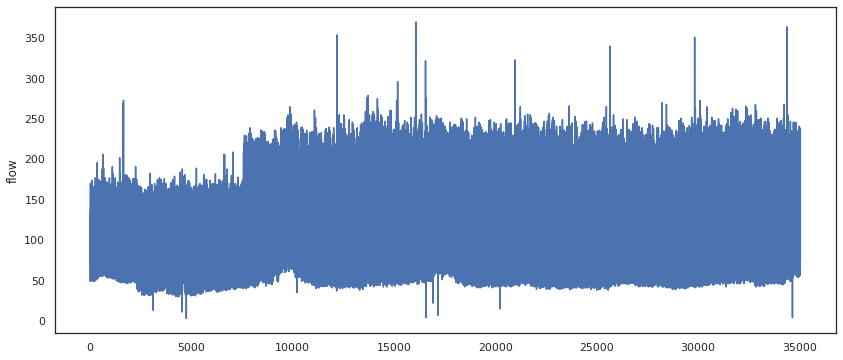

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=df['flow'], ax=ax)

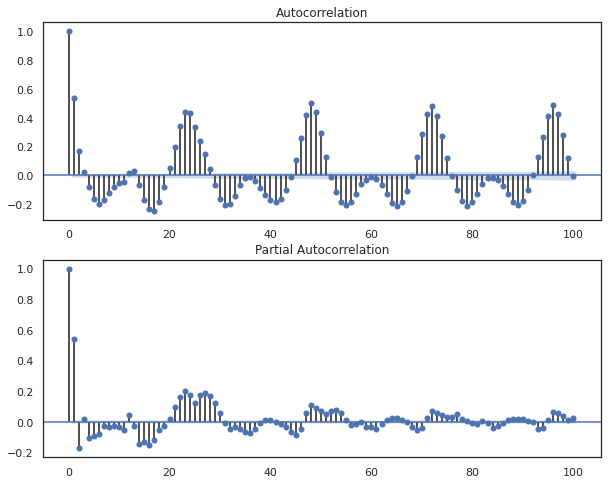

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sgt.plot_acf(df['flow'], lags = 100, ax=ax1);
sgt.plot_pacf(df['flow'], lags = 100, ax=ax2);

`-` 그래프에 2017년을 제외하면 추세는 존재하지 않고 강한 계절성이 존재한다

`-` ACF, PACF의 정의에 따라 0시점 차이는 의미가 없으므로 무시한다

`-` 계절성이 매우 강하다 (6시간, 18시간, 24시간, 1주, 1달, 1년 등)

`-` 신기한 것은 12시점(12시간)차이의 경우 자기상관이 존재하지 않는다

`-` 사이클(W 모양)이 대략 24시간 마다 반복되므로 최소 24시간 분량의 변수를 모델의 입력으로 사용해야 한다

- 추가 설명

`-`  hello 라는 단어를 생각해보자, 다음의 같은 사이클이 반복된다

`-` h $\to$ e, e $\to$ l, l $\to$ l, l $\to$ o, o $\to$ h 

`-` 만약 단어 하나만이 입력으로 주어진다면 l이 입력으로 들어왔을 때 다음에 오는 단어가 l인지 o인지 알 수 없다

`-` 하지만 연속된 단어 두개가 입력으로 주어진다면 다음에 올 단어를 예측할 수 있다

`-` 예컨대 ll 이면 o, lo 이면 h이다

`-` 이는 적산차를 예측하는 문제에서도 마찬가지이다

## 모델 학습

In [11]:
!git clone https://github.com/ts-kim/RevIN.git

Cloning into 'RevIN'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 181 (delta 62), reused 93 (delta 20), pack-reused 0
Receiving objects: 100% (181/181), 2.84 MiB | 5.38 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

import xgboost
from xgboost import XGBRegressor

from RevIN import RevIN

`-` 적용할 것: XGBoost, LSTM, SCI- Net

- 후처리

`-` 훈련 데이터를 보면 적산차값이 모두 정수형이다

`-` 예측값도 반올림하여 정수로 만들어주겠다

### XGBoost 모델 학습

`-` private 데이터는 2022-01-01-00:00:00 부터 존재할 것이다

`-` public 데이터는 2021-12-17 23:00:00 까지 존재한다

`-` 2021-12-17 23:00:00 에서 337시간 뒤는 2022-01-01 00:00:00 이다

`-` 337시간 후의 적산차를 예측하는 모델을 만드는게 적합하지만 그러면 시간상의 차이가 많이 나서 성능이 떨어진다

`-` 따라서 1시간 후의 적산차를 예측하는 모델을 만들고 존재하지 않는 시각의 정보는 예측한 정보로 대체하여 사용하겠다

`-` 1시간 후의 적산차를 예측하기 위해 pacf 그래프에 근거해 24시간 분량의 적산차를 사용하겠다

`-` 사이클을 포함하는(24시간 이상) 시계열 중 24시간 차이가 나는 데이터간의 직접적인 상관관계가 가장 크다

`-` 또한, 변수가 적으면 학습 및 추론 시간이 단축된다

In [ ]:
print('xgboost version:', xgboost.__version__)
print('sklearn version:', sklearn.__version__)

xgboost version: 0.90
sklearn version: 1.0.2


- 장점

`-` 딥러닝 모델에 비해 속도가 매우 빠르다

- 단점

`-` 다중 출력을 해야 하는 경우 속도가 배로 느려진다

`-` 예측한 결과를 모델의 입력으로 넣어서 예측하는 방법을 사용하면 모델의 속도는 더 빠르겠지만 성능이 매우 하락한다

- 위와 같은 문제로 부스팅 모델은 사용하지 않기로 함

`-` 모델을 336개 만들어야 한다

#### 모델 학습 방법

- 부스팅 모델을 사용한 지도 학습

`-` 2일치의 데이터(48개)를 가지고 다음 시점 적산차를 예측

#### 모델 학습 준비

In [ ]:
# def ts2supervised(
#     data: pd.DataFrame, 
#     ts_column: str, 
#     window: int = 48, 
#     gap: int = 1,
#     step: int = 1, 
#     dropna: bool = True
# ) -> pd.DataFrame:
#     """
#     [Z_{t-w}, Z_{t-w+1}, ..., Z_{t-1}] 데이터를 사용하여 Z_{t+gap-1}, ..., Z_{t+gap+step-2} 시점을 예측
#     """
#     ts = data.copy()
#     for i in range(1, window):
#         ts[f'{ts_column}+{i}'] = ts[ts_column].shift(-i)
#     for s in range(step):
#         ts[f'target+{window+gap+s-1}'] = ts[ts_column].shift(-(window+gap+s-1))
    
#     if dropna:
#         ts = ts.dropna()
#     return ts

In [ ]:
# args = {'ts_column':'flow', 
#         'window':24, 
#         'gap':1, 
#         'step':336}

In [ ]:
# ts = ts2supervised(df, **args)

In [ ]:
# X = ts.loc[:, 'flow+1':'flow+23'].to_numpy()
# y = ts.loc[:, 'target+24':'target+359'].to_numpy()

In [ ]:
# X_train, X_val, y_train, y_val = X[:-(X.shape[0]//5)], X[-(X.shape[0]//5):], y[:-(y.shape[0]//5)], y[-(y.shape[0]//5):]

#### 모델 학습 및 검증

`-` 학습 및 추론 속도 문제로 부스팅 모델은 사용하지 않기로 함

### LSTM 모델 학습

#### 모델 학습 방법

`-` 24시간의 적산차값을 입력으로 받아 입력의 마지막 시점의 다음 시점을 포함하여 336시간을 예측

#### 모델 학습 준비

In [66]:
args = easydict.EasyDict({
    'weight_path':'./weights',
    'model_name':'lstm',
    'window':96,
    'gap':1,
    'num_classes':336,
    'num_epochs':100,
    'bs':64,
    'lr':2e-4,
    'max_norm':1.0,
    'seed':22,
})

In [14]:
create_folder(args.weight_path)

In [15]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.enabled = False  # False 이면 재현이 가능하지만 매우 느려지므로 마지막에 사용하자

In [16]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

In [17]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {DEVICE}입니다')

현재 device는 cuda입니다


- 피쳐 스케일링

In [18]:
minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(df['flow'].values.reshape(-1, 1))
X_test_scaled = minmax_scaler.transform(test['flow'].values.reshape(-1, 1))

- 데이터 생성

In [19]:
def train_ts2supervised(
    ts: NDArray[np.float_], 
    window: int = 24,
    gap: int = 1, 
    step: int = 336
) -> Tuple[NDArray[np.float_], NDArray[np.float_]]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X, y = [], []
    for t in range(len(ts) - (window+gap+step) + 2):
        X.append(ts[t:t+window])
        y.append(ts[t+window+gap-1 : t+window+gap+step-1])
    X, y = np.array(X), np.array(y).reshape(-1, step)
    return X, y

In [20]:
X, y = train_ts2supervised(X_scaled, window=args.window, gap=args.gap, step=args.num_classes)

In [21]:
X_train, X_val, y_train, y_val = X[:-(X.shape[0]//5)], X[-(X.shape[0]//5):], y[:-(y.shape[0]//5)], y[-(y.shape[0]//5):]

- 데이터 셋과 데이터 로더

In [22]:
class CustomDataset(Dataset):
    def __init__(self, X: NDArray[np.float_], y: Optional[NDArray[np.float_]] = None) -> None:
        super(CustomDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor], Tensor]:
        X = torch.FloatTensor(self.X[idx])
        if self.y is not None:
            y = torch.FloatTensor(self.y[idx])
            return X, y
        return X

    def __len__(self) -> int:
        return self.X.shape[0]

In [23]:
def get_dataloader(X: NDArray[np.float_], y: Optional[NDArray[np.float_]] = None, shuffle=True):
    dataset = CustomDataset(X, y)    
    dataloader = DataLoader(dataset, batch_size=args.bs, shuffle=shuffle)
    return dataloader

In [67]:
# 참고: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
# 참고할 것: https://teddylee777.github.io/pytorch/pytorch-rnn
# input of shape (batch, sequence, feature(=input size)) 
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=4, num_classes=336, dropout_prob=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.revin_layer = RevIN.RevIN(input_size)  # https://github.com/ts-kim/RevIN

    def forward(self, x):  # shape of x: (Batch, Sequence, Feature)
        # x shape: (B, 96(=sequence), input_size)
        x = self.revin_layer(x, 'norm')
        # x shape: (B, 96, input_size)
        x, _ = self.lstm(x)  # h_0, c_0 기본값은 0으로 채워진 텐서
        # x shape: (B, 96, hidden_size)
        x = self.fc(x[:,-1,:])  
        # x shape: (B, num_classes)
        x = x.unsqueeze(2)
        # x shape: (B, num_classes, input_size)
        x = self.revin_layer(x, 'denorm')
        # x shape: (B, num_classes, input_size)
        return x

- early stopping

In [25]:
# ref: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
        'accuracy',
        'f1_score',
        'mae',
    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitor: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        path: str = './weights', 
        model_name: str = '',
    ) -> None:
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitor = monitor
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  # 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.path = path   # 해당 폴더 아래에 모델 가중치를 저장
        self.model_name = model_name
        self.reset_fold()  # for k-fold cross validation

    def __call__(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        # score는 클수록 좋다
        if self.monitor == 'loss':
            score = valid_loss * self.direction
        elif self.monitor in self.score_metrics:
            score = valid_metric_score * self.direction
        else:
            score = None

        # score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  # 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  # score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), f'{self.path}/{self.model_name}_best_{self.fold}.pt') 
        self.valid_loss = valid_loss  # 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  # 이때의 valid metric score도 변경

    def reset_fold(self) -> None:
        self.fold = 0

    def update_fold(self) -> None:
        self.fold += 1

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

In [26]:
early_stopping = EarlyStopping(patience=10,
                               monitor='mae',
                               mode='min',
                               path=args.weight_path,
                               model_name=args.model_name)

- 손실 함수

In [27]:
loss_fn = nn.L1Loss()  # MAE

#### 모델 학습 및 검증

In [58]:
def train(
    model: nn.Module,
    dataloader: DataLoader, 
    device: torch.device,
    loss_fn: _Loss, 
    optimizer: Optimizer, 
    scheduler: Optional[_LRScheduler] = None
) -> Tuple[nn.Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0
    model.to(device)
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    for X, y in dataloader:  
        X, y = X.to(device), y.to(device) 
        with torch.cuda.amp.autocast():
            y_hat = model(X)
            y_hat = y_hat.squeeze(2)
            loss = loss_fn(y_hat, y)  

        optimizer.zero_grad()  
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=args.max_norm)
        scaler.step(optimizer)
        scaler.update()
        train_loss += (loss.item() / len(dataloader)) 
  
    # 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()
        
    return model, train_loss

In [62]:
def evaluate(
    model: nn.Module, 
    dataloader: DataLoader, 
    device: torch.device,
    loss_fn: _Loss
) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 ACD f1 score를 반환"""
    valid_loss = 0.0
    y_list, yhat_list = np.array([]).reshape(0, args.num_classes), np.array([]).reshape(0, args.num_classes)
    model.to(device)
    model.eval()  

    with torch.no_grad():  
        for X, y in dataloader:  
            X, y = X.to(device), y.to(device) 
            y_hat = model(X)
            y_hat = y_hat.squeeze(2)
            loss = loss_fn(y_hat, y)  
            y = y.detach().cpu().numpy()  # y shape: (B, 336)
            y_hat = y_hat.detach().cpu().numpy()  # yhat shape: (B, 336)
            y_list = np.concatenate([y_list, minmax_scaler.inverse_transform(y)])
            yhat_list = np.concatenate([yhat_list, minmax_scaler.inverse_transform(y_hat)])
            valid_loss += (loss.item() / len(dataloader))

    valid_mae = mean_absolute_error(y_list, yhat_list)        
    return valid_loss, valid_mae

In [30]:
def holdout_validate(
    model: nn.Module, 
    X_train: NDArray[np.float_],
    y_train: NDArray[np.float_],
    X_val: NDArray[np.float_],
    y_val: NDArray[np.float_],
    loss_fn: _Loss, 
    early_stopping: EarlyStopping,
    device: torch.device,
) -> Tuple[nn.Module, List[List[float]], List[List[float]]]:
    """K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 검증 손실을 반환"""
    seed_everything(args.seed)  # 정확한 재현을 위함
    fold_valid_loss = []   # 폴드별 best 검증 손실
    fold_train_losses_per_epoch = [[]]  # 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[]]  # 폴드별 1 에폭에 따른 검증 배치 손실
    early_stopping.reset_fold()  # fold 초기화

    print(f'[1 / 1] Fold Training......')

    # 메모리 절약
    clear_gpu()

    # Dataloader
    train_dataloader = get_dataloader(X_train, y_train)
    valid_dataloader = get_dataloader(X_val, y_val, shuffle=False)

    # optimizer
    optimizer = optim.AdamW(model.parameters(), lr=args.lr) 

    # scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # early stopping, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
    early_stopping.reset_score()
    early_stopping.update_fold()  
    
    # 폴드마다 모델 학습
    for epoch in tqdm(range(1, args.num_epochs+1)):  # (배치사이즈 X 에폭) 만큼 훈련시킴           
        model, train_loss = train(model, train_dataloader, device, loss_fn, optimizer, scheduler)  # 모델 학습
        valid_loss, valid_mae = evaluate(model, valid_dataloader, device, loss_fn)  # 모델 평가
        fold_train_losses_per_epoch[0].append(train_loss) 
        fold_valid_losses_per_epoch[0].append(valid_loss)  

        print_score_condition = (epoch == 1 or epoch % 2 == 0 or epoch == args.num_epochs)  
        score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid MAE = {valid_mae:.5f}'

        # 평균 배치 훈련 오차와 검증 오차 출력
        if print_score_condition:  
            print(score_information)  
            
        # 에폭마다 early stopping 실행
        early_stopping(model, valid_loss, valid_mae)  
        if early_stopping.early_stop: 
            if not print_score_condition:  # 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                print(score_information) 
            print('Early Stopping!')
            break 

    fold_valid_loss.append(early_stopping.valid_loss)  # 폴드별 best 검증 손실
      
    # 폴드별 학습 및 검증 종료시 best 검증 손실을 출력
    print(f'1 Fold -> Valid Loss: {early_stopping.valid_loss:.5f}  Valid MAE: {early_stopping.valid_metric_score:.5f}')
    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

In [68]:
seed_everything(args.seed)
model = LSTMModel(input_size=1, hidden_size=256, num_layers=4, num_classes=args.num_classes, dropout_prob=0.1).to(DEVICE)

In [70]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = holdout_validate(model, X_train, y_train, X_val, y_val,
                                                                                   loss_fn, early_stopping, DEVICE)

[1 / 1] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.06857  valid loss = 0.06303  valid MAE = 23.13553
[Epoch:  2]  train loss = 0.06034  valid loss = 0.06276  valid MAE = 23.03518
[Epoch:  4]  train loss = 0.05995  valid loss = 0.06217  valid MAE = 22.81777
[Epoch:  6]  train loss = 0.05975  valid loss = 0.06224  valid MAE = 22.84699
[Epoch:  8]  train loss = 0.05960  valid loss = 0.06215  valid MAE = 22.81010
[Epoch: 10]  train loss = 0.05753  valid loss = 0.06352  valid MAE = 23.31583
[Epoch: 12]  train loss = 0.05358  valid loss = 0.06158  valid MAE = 22.60168
[Epoch: 14]  train loss = 0.05284  valid loss = 0.06137  valid MAE = 22.52252
[Epoch: 16]  train loss = 0.05250  valid loss = 0.06134  valid MAE = 22.51335
[Epoch: 18]  train loss = 0.05234  valid loss = 0.06113  valid MAE = 22.43646
[Epoch: 20]  train loss = 0.05204  valid loss = 0.06110  valid MAE = 22.42900
[Epoch: 22]  train loss = 0.05188  valid loss = 0.06129  valid MAE = 22.49777
[Epoch: 24]  train loss = 0.05168  valid loss = 0.06087  valid M

- 에폭에 따른 손실의 변화

In [71]:
def show_loss_plot(
    fold_train_losses: List[List[float]],
    fold_valid_losses: List[List[float]]
) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    # 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    # 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

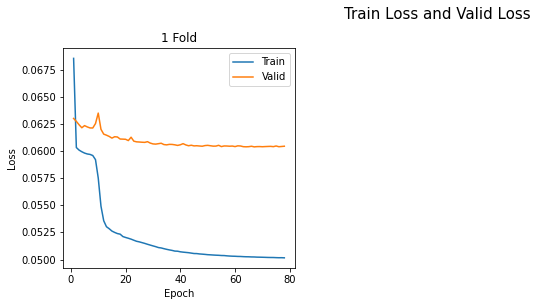

In [72]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

#### Test 예측

`-` 예측을 위해 스케일링된 train과 test를 병합

In [73]:
def test_ts2supervised(
    ts: NDArray[np.float_], 
    window: int = 24
) -> NDArray[np.float_]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X = []
    for t in range(len(ts) - window + 1):
        X.append(ts[t:t+window])
    X = np.array(X)
    return X

In [82]:
def predict(
    model: nn.Module, 
    X: NDArray[np.float_],
    weight_folder_path: str,
    device: torch.device
) -> Tensor:   
    weight_paths = glob(weight_folder_path + '/*.pt')
    dataloader = get_dataloader(X, shuffle=False)
    test_preds = torch.zeros(len(dataloader.dataset), args.num_classes)  
    num_folds = len(weight_paths)
     
    for weight_path in tqdm(weight_paths):
        preds = np.array([]).reshape(0, args.num_classes)
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.to(device)
        model.eval()

        with torch.no_grad(): 
            for X in dataloader:  # test 데이터는 라벨(y)이 없다
                X = X.to(device)  # shape of X: (Batch, Sequence, Feature)
                y_hat = model(X).detach().cpu().squeeze(2).numpy()  # shape of yhat: (Batch, Class)
                preds = np.concatenate([preds, y_hat]) 

        test_preds += (preds / num_folds) 
    return test_preds     

In [74]:
X_test = np.concatenate([X_scaled[-args.window:], X_test_scaled])

In [75]:
X_test = test_ts2supervised(X_test, window=args.window)

In [83]:
preds = predict(model, X_test, args.weight_path, DEVICE)

  0%|          | 0/1 [00:00<?, ?it/s]

In [88]:
submission.loc[:, 'h0':'h335'] = np.round(minmax_scaler.inverse_transform(preds))

In [129]:
submission.to_csv('./data/submission.csv')